# Make a fake stead-state landscape using SPACE + Run Hyland for creating landslides.

* Campforts, B., Shobe, C. M., Overeem, I., & Tucker, G. E. (2022). The Art of Landslides: How Stochastic Mass Wasting Shapes Topography and Influences Landscape Dynamics. Journal of Geophysical Research: Earth Surface, 127(8), 1–16. [doi: 10.1029/2022JF006745](https://doi.org/10.1029/2022JF006745)
* Campforts B., Shobe C.M., Steer P., Vanmaercke M., Lague D., Braun J. (2020) HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution. Geosci Model Dev: 13(9):3863–86, [doi: 10.5194/gmd-13-3863-2020](https://doi.org/10.5194/gmd-13-3863-2020).

### Step 1: Import the necessary libraries 

The BedrockLandslider and SPACE components are required, as are the model grid component and a flow routing component. We will use the `PriorityFloodFlowRouter` that takes care of routing flow across flats or pits in a digital elevation model.

In [1]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter
from landlab.io.esri_ascii import write_esri_ascii

Three Landlab components are essential to running the BedrockLandslider model: the model itself, the SPACE model and the `PriorityFloodFlowRouter`, which calculates drainage pathways, topographic slopes, and surface water discharge across the grid. The `PriorityFloodFlowRouter` will act as a depression handler which is useful if a grid is likely to have pits or closed depressions. 

In addition to the relevant process components, some Landlab utilities are required to generate the model grid (in this example `RasterModelGrid`) and to visualize output (`imshowhs_grid`). Note that while it is possible to visualize output through functionality in other libraries (e.g., matplotlib), `imshowhs_grid` provides a simple way to generate 2-D maps of model variables.

Most Landlab functionality requires the Numpy package for scientific computing in python. The matplotlib plotting library has also been imported to aid visualization of results.

### Step 2: Define the model domain and initial conditions

In [2]:
# Set grid parameters
num_rows = 30
num_columns = 30
node_spacing = 25.0

# track sediment flux at the node adjacent to the outlet at lower-left
node_next_to_outlet = num_columns + 1

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
# add field ’topographic elevation’ to the grid
mg.add_zeros("node", "topographic__elevation")
# set constant random seed for consistent topographic roughness
np.random.seed(seed=10000)

# Create initial model topography:

# add topographic roughness
random_noise = (
    np.random.rand(len(mg.node_y)) / 1000.0
)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += random_noise

# add field 'soil__depth' to the grid
mg.add_zeros("node", "soil__depth")

# Set 2 m of initial soil depth at core nodes
mg.at_node["soil__depth"][mg.core_nodes] = 1.0  # meters

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Sum 'soil__depth' and 'bedrock__elevation'
# to yield 'topographic elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

### Step 3: Set the boundary conditions

The user must determine the boundary conditions of the model domain (i.e., determine across which boundaries water and sediment may flow). Boundary conditions are controlled by setting the status of individual nodes or grid edges (see Hobley et al., 2017). Here, we keep all boundaries open so that water and sediment can leave the domain at all times over all edges. 

In [3]:
## Open all model boundary edges --changed Larry's.
#mg.set_closed_boundaries_at_grid_edges(
#    bottom_is_closed=True,
#    left_is_closed=True,
#    right_is_closed=True,
#    top_is_closed=True,
#)
#mg.status_at_node[5] = 1 

# the way Nilay set the BCs
mg.status_at_node[mg.status_at_node==1] = 4
mg.status_at_node[0] = 1

### Step 4: Initialize the flow director and SPACE 

Like most Landlab components, PriorityFloodFlowRouter, SPACE and BedrockLandslider are written as a Python classes. The class was imported at the beginning of the driver script (step 1). In this step, the user declares the instance of the PriorityFloodFlowRouter and SPACE classes and sets any relevant model parameters. At this point we do not yet make an instance of the BedrockLandslider component. 

In [4]:
# Instantiate flow router
fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)

# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(
    mg,
    K_sed=2.5e-5,
    K_br=2.5e-5,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

### Step 5: Run the time loop to develop a landscape without landslide activity

The SPACE component calculates sediment entrainment and deposition, bedrock erosion, and changes in land surface elevation over time. The code shown below is an example of how to run the SPACE model over several model timesteps. In the example below, SPACE is run in a loop that executes until elapsed model time has reached a user-defined run time. The user is also responsible for choosing the model timestep. Within the loop, the following steps occur:

1. The flow router runs first to determine topographic slopes and water discharge at all nodes on the model domain.
2. The depression finder and router runs to map any nodes located in local topographic minima (i.e., nodes that water cannot drain out of) and to establish flow paths across the surface of these “lakes.” Using the depression finder and router is optional. However, because the SPACE model may in certain situations create local minima, using the depression finder and router can prevent the development of fatal instabilities.
3. The depression finder and router generates a list of flooded nodes, which is then saved as a variable called “flooded” and passed to the SPACE model.
4. The SPACE model runs for the duration of a single timestep, computing sediment transport, bedrock erosion, and topographic surface evolution.
5. The elapsed time is updated.

0.20 of model run completed


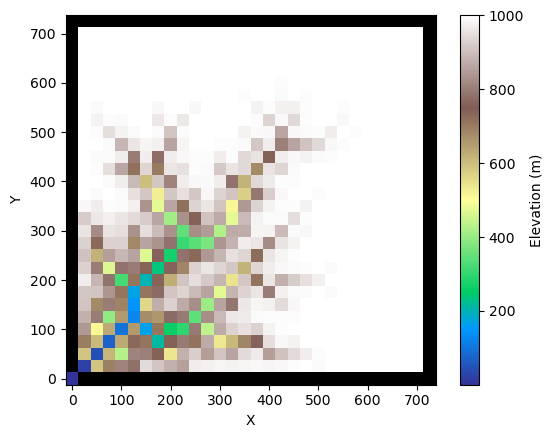

0.40 of model run completed


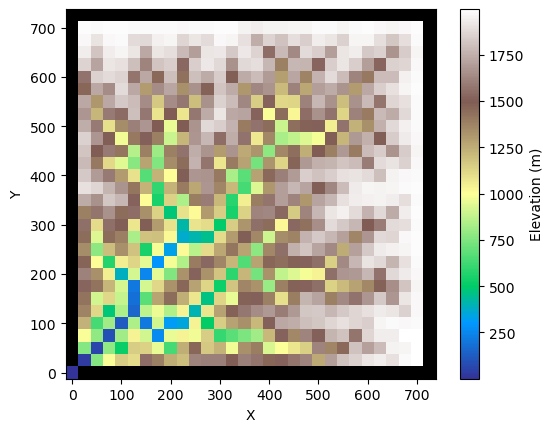

0.60 of model run completed


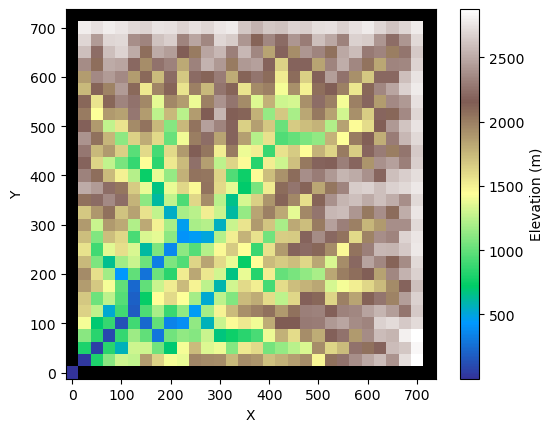

0.80 of model run completed


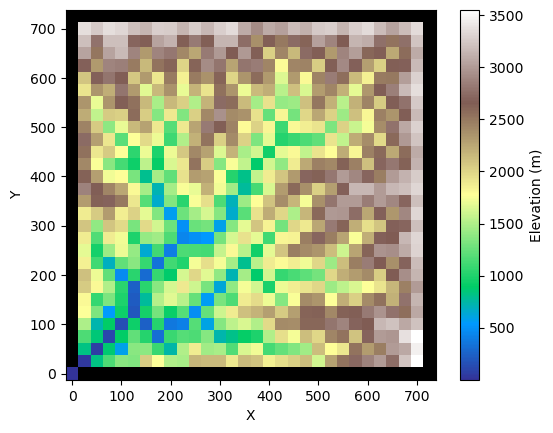

1.00 of model run completed


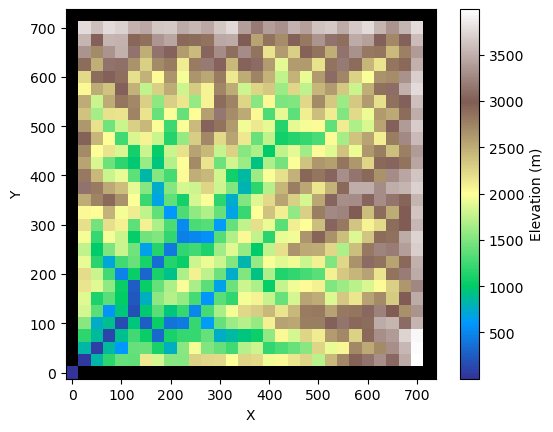

In [5]:
# Set model timestep
timestep = 5e2  # years

# Set elapsed time to zero
elapsed_time = 0.0  # years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 5e5  # years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

# Uplift rate in m/yr
U = 1e-2

cmap = copy.copy(mpl.colormaps["terrain"])

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
    mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))
        imshow_grid(
            mg, "topographic__elevation", cmap=cmap, colorbar_label="Elevation (m)"
        )
        plt.show()

## Visualization of results

### Topography and soil depth

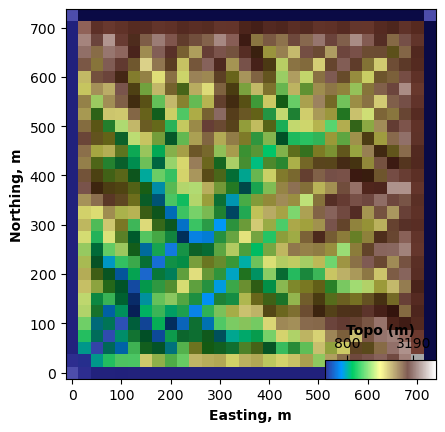

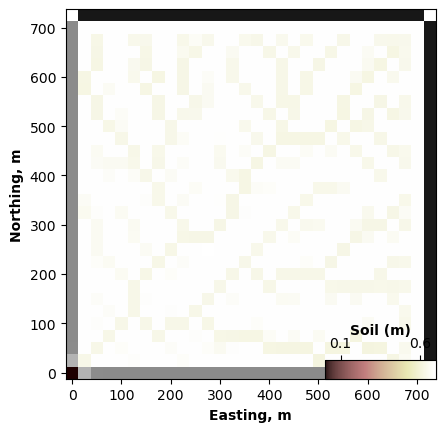

In [6]:
cmap = copy.copy(mpl.colormaps["terrain"])
# Show DEM draped over the shaded topographic relief
imshowhs_grid(
    mg,
    "topographic__elevation",
    var_name="Topo",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)
plt.show()
# Show Soil thickness draped over the shaded topographic relief
cmap = copy.copy(mpl.colormaps["pink"])
imshowhs_grid(
    mg,
    "topographic__elevation",
    drape1=mg.at_node["soil__depth"],
    plot_type="Drape1",
    var_name="Soil",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)

z_before_LS = np.array(mg["node"]["topographic__elevation"])
#br_before_LS = np.array(mg["node"]["bedrock__elevation"]) # Added by Nilay
#sd_before_LS = np.array(mg["node"]["soil__depth"]) # Added by Nilay

(0.0, 3886.618298244418)

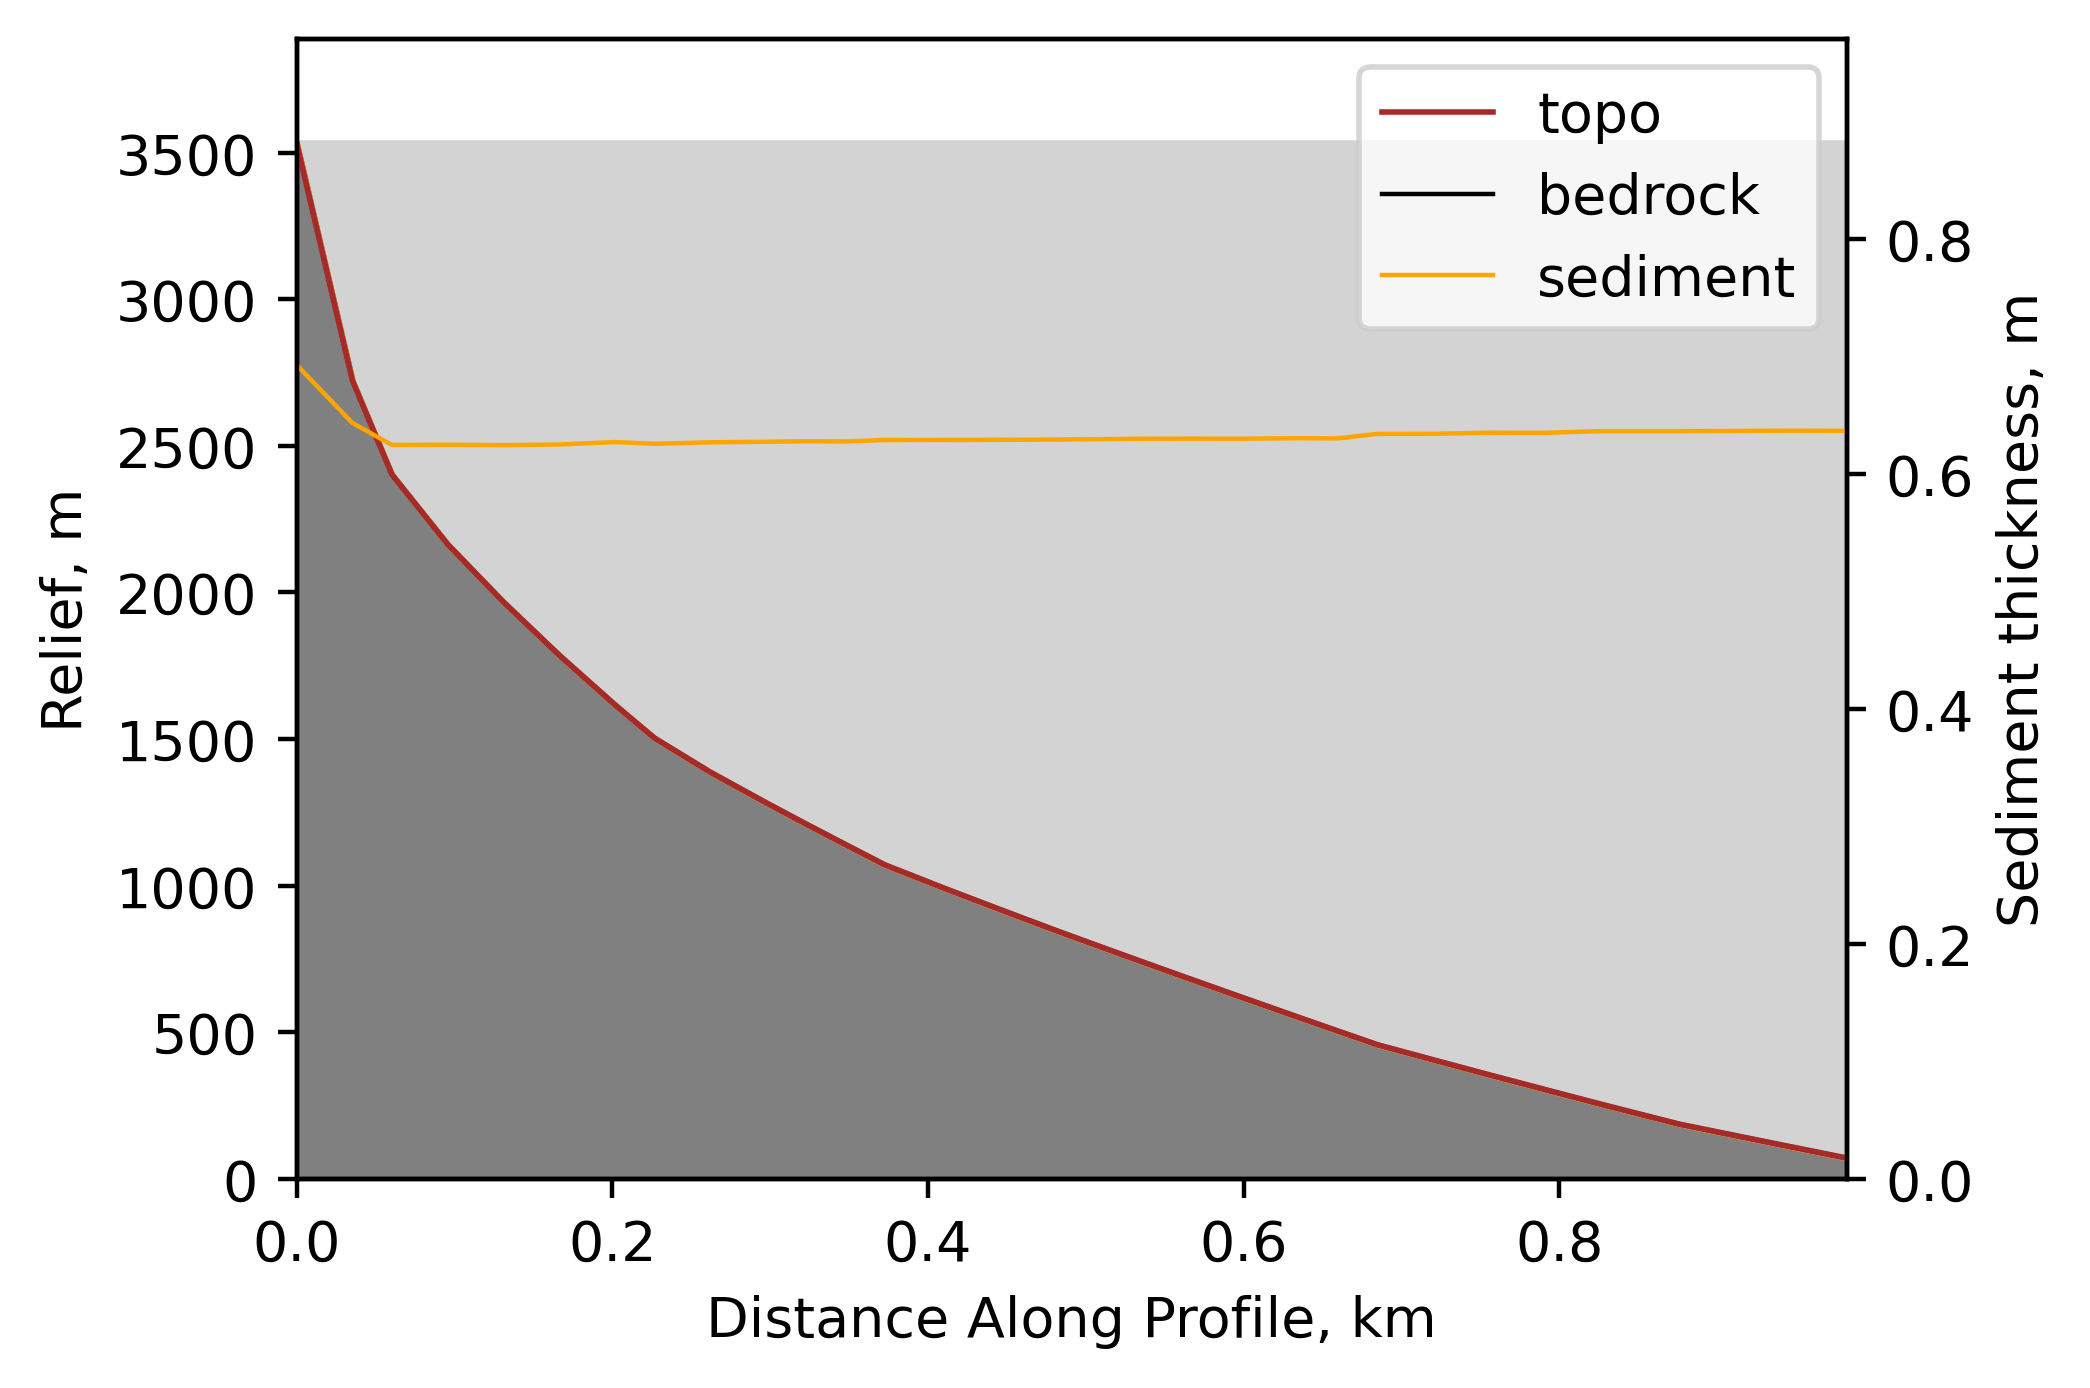

In [11]:
# channel profiles with sediment   ------- SUSANNAH's CODE ---------
from landlab.components import ChannelProfiler

profiler = ChannelProfiler(mg) # Susannah's
profiler.run_one_step()
riv_nodes = profiler.nodes

mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
dist_atNodes=profiler.distance_along_profile[0]

el = mg.at_node["topographic__elevation"][riv_nodes]
sd = mg.at_node["soil__depth"][riv_nodes]

br = el-sd     # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel() # Calculate minimum elevation and relief

min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = mg.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nanplt_fontsize =10     

fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()

dist = (max(dist_atNodes)-dist_atNodes)*1e-3 
brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
ax1.tick_params(labelsize=10.0)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
ax2.set_ylim((0, np.nanmax(sd)*1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=10.0) # Merge legends

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
ax1.set_ylim(bottom=0)

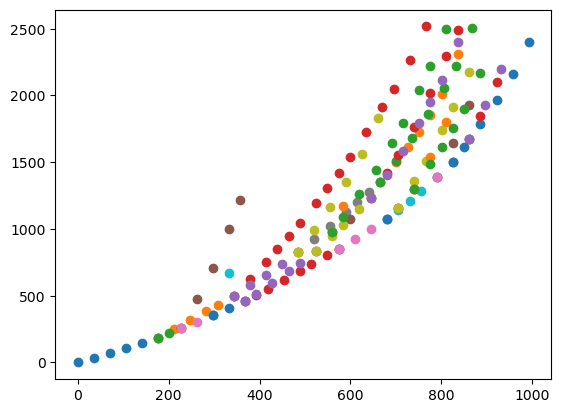

In [12]:
# channel profiles with sediment   ------- NiLAY added this, longer code ---------
from landlab.components import ChannelProfiler

dx = node_spacing
area_threshold = dx*dx*10.

profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=area_threshold, main_channel_only=False)
profiler.run_one_step()

#plot channel profiles

outlets = list(profiler.data_structure.keys()) #outlets from channel profiler
for outlet in outlets: #cycle thru outlets
    segments = list(profiler.data_structure[outlet].keys()) #segments for that watershed
    #print(segments)
    for i, segment in enumerate(segments): #cycle thru segments
        ids = profiler.data_structure[outlet][segment]['ids'] #ids (index) of each segment
        distance = profiler.data_structure[outlet][segment]['distances']#distance downstream of each segment node
        eta = mg.at_node['topographic__elevation'][ids] #elevation of each segment node
        plt.scatter(distance,eta,alpha=1) #plot profile
        #plt.plot(distance,eta,color='green',alpha=1)   
plt.show()

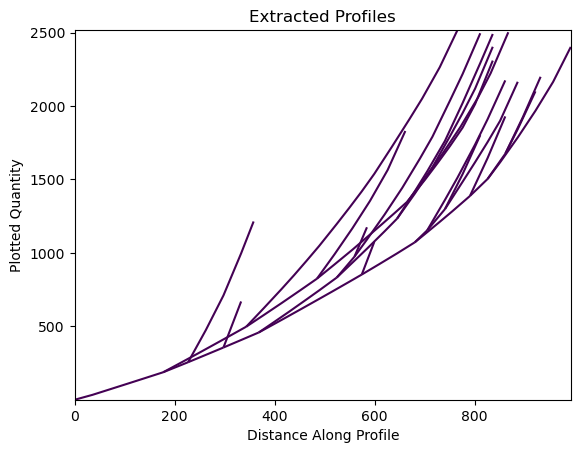

In [13]:
# VERY EASY WAY from methods/functions of the component:

profiler.plot_profiles()

In [14]:
profiler.data_structure

# ASK How to hold data
#distance_list = []
#elevation_list = []


OrderedDict([(0,
              OrderedDict([((0, 155),
                            {'ids': array([  0,  31,  62,  93, 124, 155]),
                             'distances': array([   0.        ,   35.35533906,   70.71067812,  106.06601718,
                                     141.42135624,  176.7766953 ]),
                             'color': (0.26700400000000002,
                              0.0048739999999999999,
                              0.32941500000000001,
                              1.0)}),
                           ((155, 160),
                            {'ids': array([155, 126,  97, 128, 129, 160]),
                             'distances': array([ 176.7766953 ,  212.13203436,  247.48737342,  282.84271247,
                                     307.84271247,  343.19805153]),
                             'color': (0.26700400000000002,
                              0.0048739999999999999,
                              0.32941500000000001,
                              1.0)}

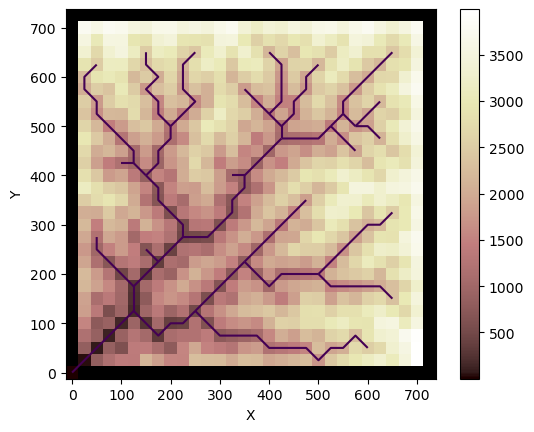

In [15]:
profiler.plot_profiles_in_map_view()

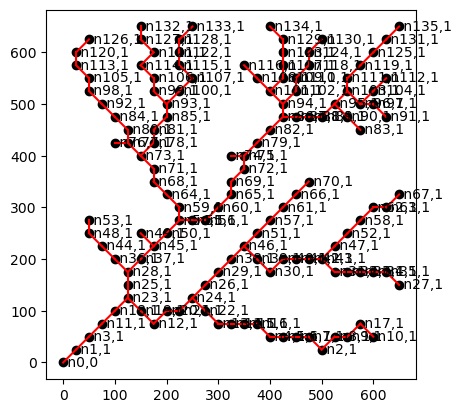

In [16]:
from landlab.grid.create_network import network_grid_from_raster

#make raster grid into network grid
network_grid = network_grid_from_raster(mg,minimum_channel_threshold=area_threshold,include=["drainage_area", "topographic__elevation", "soil__depth", "sediment__flux"])

#plotting the network grid
plt.figure()

#plot all nodes
plt.scatter(network_grid.x_of_node,network_grid.y_of_node,color='k')

#label nodes with soil depth
for i in range(0,network_grid.number_of_nodes):
     plt.text(network_grid.x_of_node[i],network_grid.y_of_node[i],' n'+str(i)+',' +str(round(network_grid.at_node['soil__depth'][i])) ,va='center',ha='left')
    
#plot the links
for i in range(0,network_grid.number_of_links):
    i1 = network_grid.nodes_at_link[i][0]
    i2 = network_grid.nodes_at_link[i][1]
    x1,y1 = network_grid.x_of_node[i1],network_grid.y_of_node[i1]
    x2,y2 = network_grid.x_of_node[i2],network_grid.y_of_node[i2]
    plt.plot([x1,x2],[y1,y2],color='r')
plt.gca().set_aspect('equal')
plt.show() 

### Step 6: Initialize the flow director and SPACE and BedrockLandslider components

In [17]:
# Instantiate flow router, with additional multiple flow director for hillslopes
fr = PriorityFloodFlowRouter(
    mg,
    flow_metric="D8",
    separate_hill_flow=True,
    hill_flow_metric="Quinn",
    update_hill_flow_instantaneous=True,
)

# Instantiate SPACE model with chosen parameters
hy = BedrockLandslider(
    mg,
    angle_int_frict=0.4,
    cohesion_eff=1e3,
    landslides_return_time=1000,
    landslides_on_boundary_nodes=False,
)

### Step 7: Run the time loop over 200 years to develop a landscape with landslide activity

Like before, uplift will be inserted, the flow routers will be updated and the SAPCELargeScaleEroder will be run, but this time, landslides will be actively simulated.  

In [19]:
# Reset elevation back to elevation simulated without landslides to test various landslide configuration settings

mg["node"]["topographic__elevation"][:] = z_before_LS
timestep = 1  # years
landslides_size_all_steps = []

for i in range(10):
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Run BedrockLandslider for one time step
    hy.run_one_step(dt=timestep)

    # Store landslide sizes of current time step into general ls_size list
    landslides_size_all_steps = np.append(landslides_size_all_steps, hy.landslides_size)

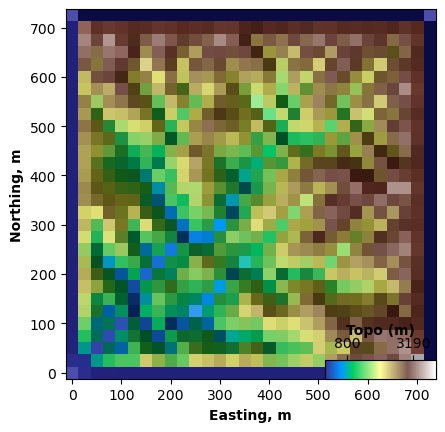

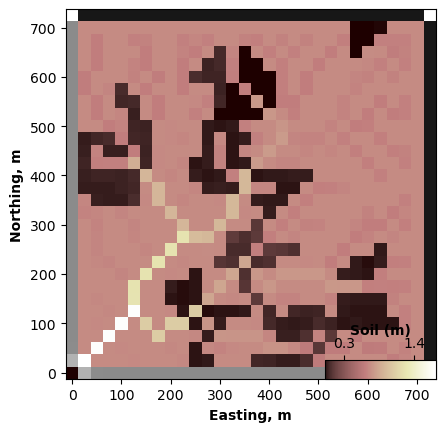

In [24]:
cmap = copy.copy(mpl.colormaps["terrain"])
# Show DEM draped over the shaded topographic relief
imshowhs_grid(
    mg,
    "topographic__elevation",
    var_name="Topo",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)
plt.show()
# Show Soil thickness draped over the shaded topographic relief
cmap = copy.copy(mpl.colormaps["pink"])
imshowhs_grid(
    mg,
    "topographic__elevation",
    drape1=mg.at_node["soil__depth"],
    plot_type="Drape1",
    var_name="Soil",
    var_units=r"m",
    grid_units=("m", "m"),
    cmap=cmap,
    ticks_km=False,
)

z_after_LS = np.array(mg["node"]["topographic__elevation"])
#br_after_LS = np.array(mg["node"]["bedrock__elevation"]) # Added by Nilay
#sd_after_LS = np.array(mg["node"]["soil__depth"]) # Added by Nilay

(0.0, 3844.945657024394)

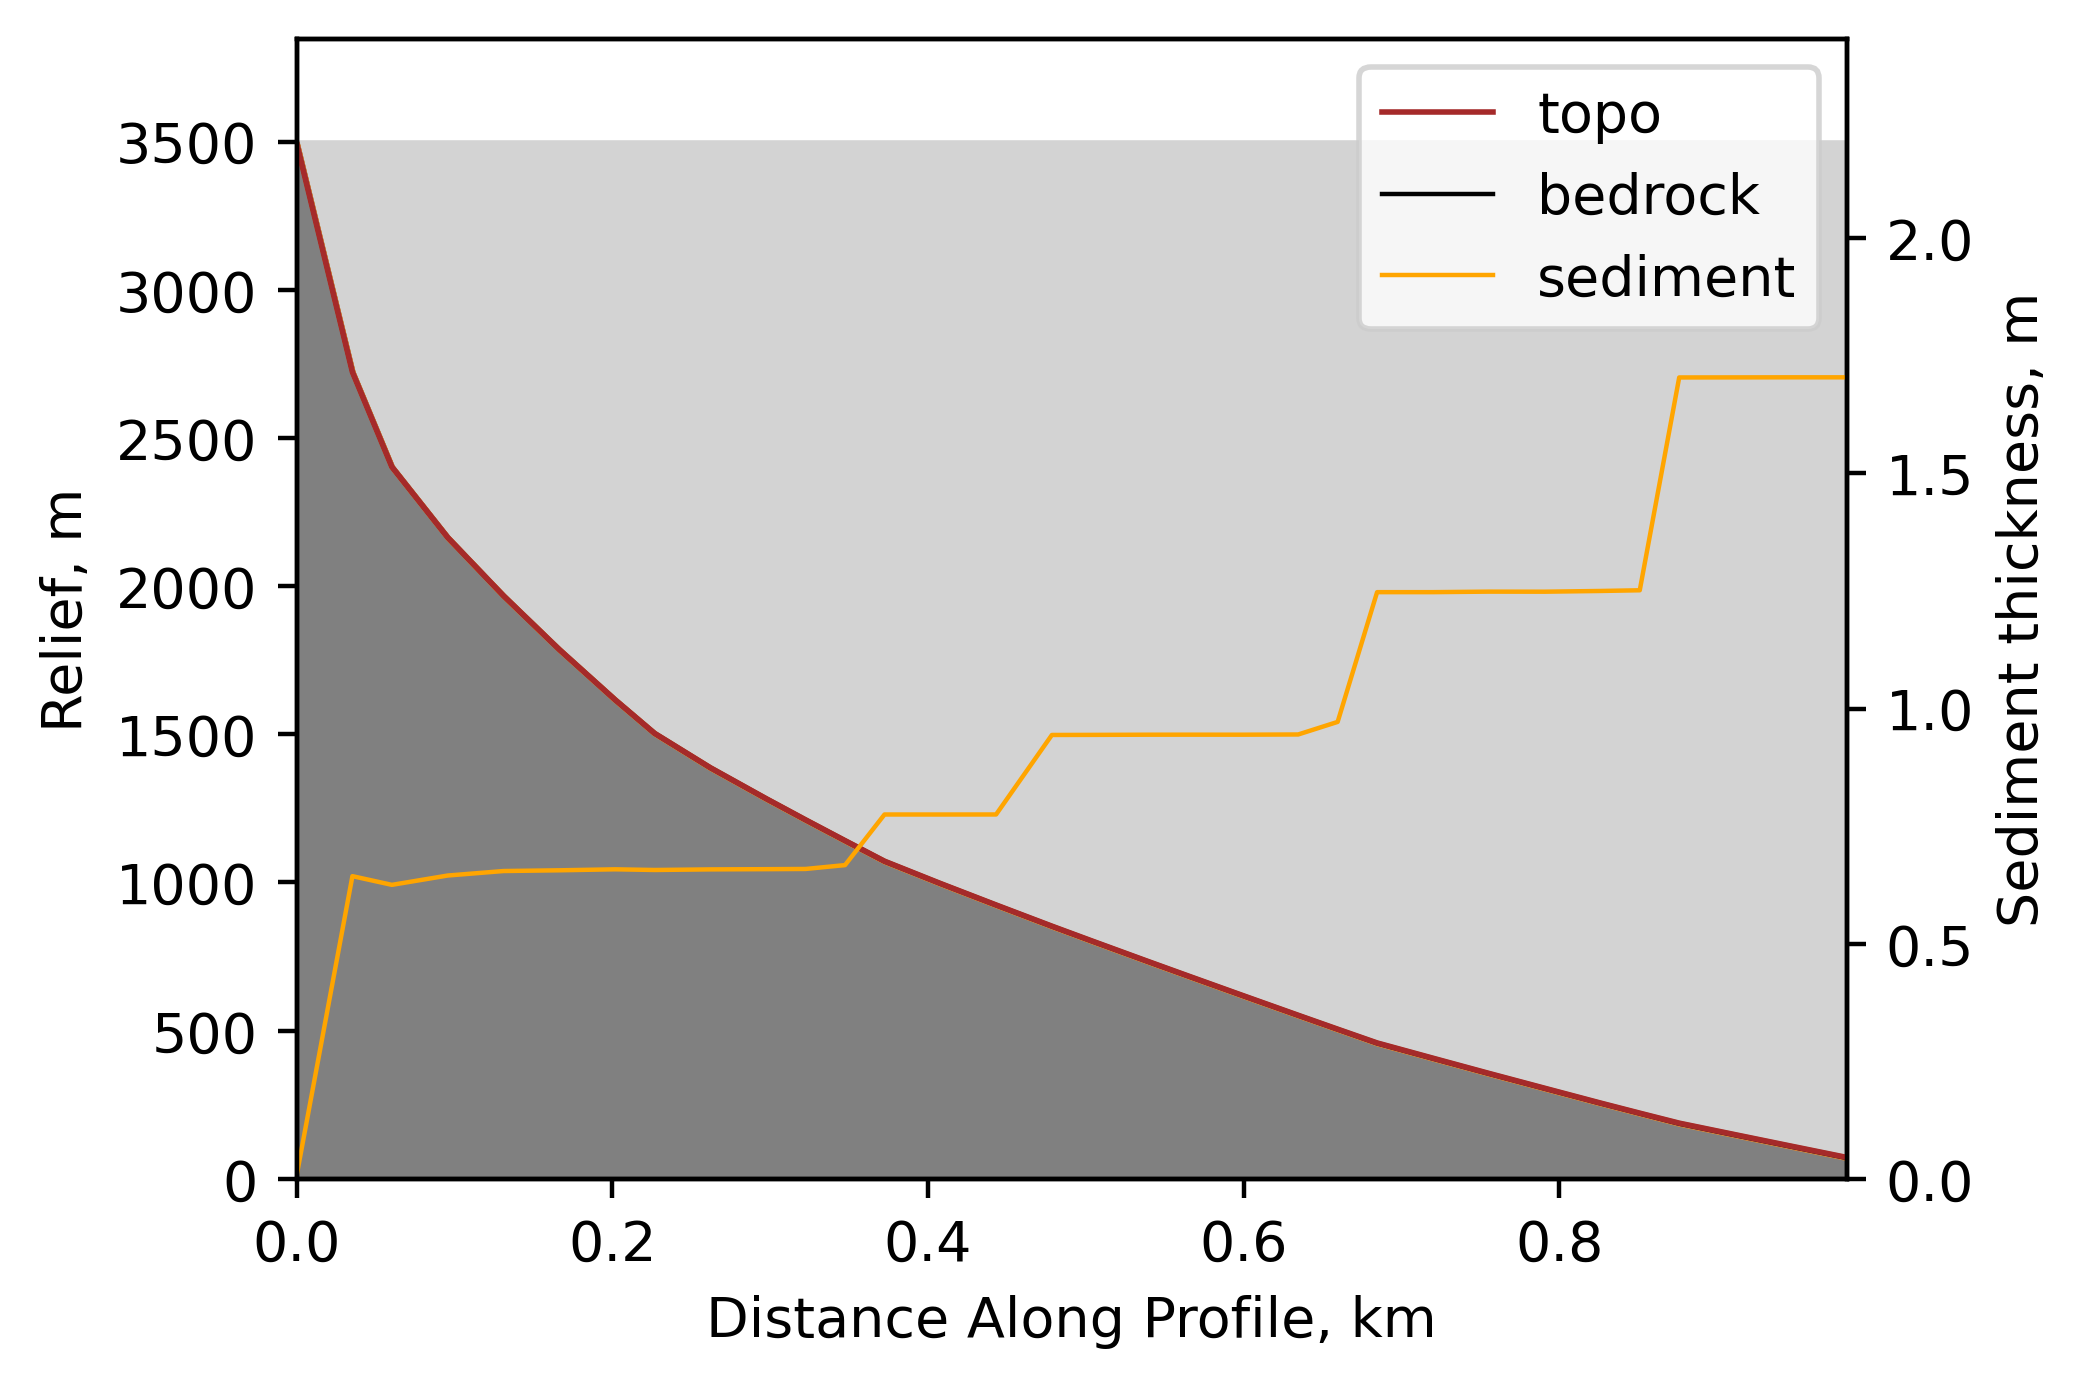

In [21]:
# channel profiles with sediment   ------- SUSANNAH's CODE ---------
from landlab.components import ChannelProfiler

profiler = ChannelProfiler(mg) # Susannah's
profiler.run_one_step()
riv_nodes = profiler.nodes

mg.at_node["bedrock_elevation"]=mg.at_node["topographic__elevation"]-mg.at_node["soil__depth"]
dist_atNodes=profiler.distance_along_profile[0]

el = mg.at_node["topographic__elevation"][riv_nodes]
sd = mg.at_node["soil__depth"][riv_nodes]

br = el-sd     # Use ravel() to flatten el and br to 1D
el = el.ravel()
sd = sd.ravel()
br = br.ravel() # Calculate minimum elevation and relief

min_elevation = min(np.min(el), np.min(br), 0)
el_relief = el - min_elevation
br_relief = br - min_elevation

qs = mg.at_node["sediment__flux"][riv_nodes]
qs[np.where(qs<10)] = np.nanplt_fontsize =10     

fig, ax1 = plt.subplots(figsize=(5,3.7), dpi=400)
ax2 = ax1.twinx()

dist = (max(dist_atNodes)-dist_atNodes)*1e-3 
brown_c = [205/255,133/255,63/255] # Fill the entire area from max relief to 0

ax1.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area') # Fill the bedrock and colluvial material relief
ax1.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
ax1.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material') # Plot bedrock and topographic relief

lns2 = ax1.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
lns1 = ax1.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4) # set up labels

ax1.set_xlabel('Distance Along Profile, km', fontweight='normal', fontsize=10.0)
ax1.tick_params(labelsize=10.0)
ax1.set_ylabel('Relief, m', fontweight='normal', fontsize=10.0)
ax1.set_ylim((0, np.max(el_relief)*1.1))


# plot sediment thickness
lns3 = ax2.plot(dist, sd, color='orange', label ='sediment', linewidth=0.8)

ax2.set_ylabel('Sediment thickness, m', fontweight='normal', fontsize=10.0)
ax2.set_ylim((0, np.nanmax(sd)*1.4))
ax2.set_xlim((0, dist[2]))
ax2.tick_params(labelsize=10.0) # Merge legends

lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]

ax1.legend(lns, labs, fontsize=10.0) # Set y-axis to start from 0
ax1.set_ylim(bottom=0)

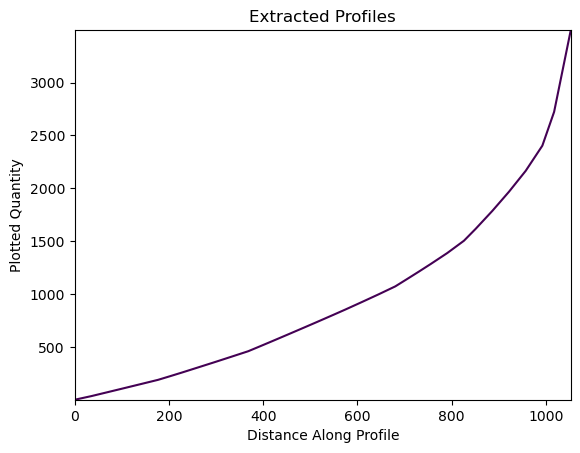

In [22]:
profiler.plot_profiles()

## Visualization of results
### Magnitude frequency of landslides simulated over 200 years

In [ ]:
LS_size = landslides_size_all_steps * mg.dx**2
counts, bins = np.histogram(np.log10(LS_size), 10)
plt.hist(np.log10(LS_size), log=True, bins=bins, density=True)
plt.xlabel("log10 LS Area, m2")
plt.ylabel("Landslide frequency")

### Location of landslides during last model iteration
Let's plot the resulting landslides 

In [ ]:
# Landslide Erosion
cmap = copy.copy(mpl.colormaps["hot_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__erosion"]),
    colorbar_label="SQRT( Landslide erosion, m) ",
    cmap=cmap,
)
plt.show()

# Landslide Deposition
cmap = copy.copy(mpl.colormaps["winter_r"])
imshow_grid(
    mg,
    np.sqrt(mg.at_node["landslide__deposition"]),
    colorbar_label="SQRT( Landslide deposition, m) ",
    cmap=cmap,
)
plt.show()

### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>